# 可解释公平指标

@version 1.4

![图片](./assets/2024-05-27-流程图.drawio.svg)

## SHAP-Fairness 指标

### 两个样本之间的 SHAP 可解释距离（在敏感属性上）

Shapley Distance between Individual and Individual

SDII

其中 $A$ 是敏感属性集合

$$
D(x_i, x_j, A) =
\sum_{f\in A}^f
|\phi_i^f-\phi_j^f|
$$

### 样本在群体之间的可解释距离

已知

$$
a = x_i^A \\
X^a  = \{x | x \in X \cap x^A \equiv a \} \\
m = {\rm count}(X^a) \\
$$

Shapley Distance between Individual and Group

SDIG

$$
D(x_i, X^a, A) = \frac 1{m-1} \sum_{x_j \in X^a \backslash x_i}^{x_j} D(x_i, x_j, A)
$$

## 实验基本环境设置

In [1]:
# 导入依赖
import numpy as np
import pandas as pd
# from rich import print
import matplotlib.pyplot as plt
import os
np.random.seed(42)

In [2]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

## 自定义函数

In [3]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model  # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult_0518 import (
    X_train,
    y_train,
    X_test,
    y_test,
    sex,
    feature_index,
    idxs_loc_male,
    idxs_loc_female,
)  # 获得 数据集 测试集 和 测试集上的敏感属性

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Xgboost-Baseline

In [4]:
import xgboost

model_xgboost_baseline, res_xgboost_baseline = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="xgboost-baseline-组",
)
res_xgboost_baseline

{'准确率(1)': 0.8624219469751254,
 '精确率(0)': 0.7683765203595981,
 '召回率(1)': 0.6159389571852479,
 'FPR(0)': 0.05910931174089069,
 'FNR(0)': 0.384061042814752,
 'F1 Score(1)': 0.6837647058823529,
 '人口平等 差异(0)': 0.16989595884523423,
 '人口平等 比率(1)': 0.32250719180485066,
 '机会均等 差异(0)': 0.08764799066199769,
 '机会均等 比率(1)': 0.29597011190360795}

## 计算得到 Shapley Value

In [5]:
# 计算得到 shapley values
import shap

def get_shapley_value(model, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    return shap_values

shap_values = get_shapley_value(model_xgboost_baseline, X_train)

In [6]:
# 获得 shapley values
shapley_values = shap_values.values
shapley_values.shape

(22792, 14)

## 将 X_train 拆分为 male 和 female

In [7]:
# 在 X_train 训练集上，已知 loc 获得 iloc
idxs_iloc_in_X_train_male = X_train.index.get_indexer(idxs_loc_male)
idxs_iloc_in_X_train_female = X_train.index.get_indexer(idxs_loc_female)

In [8]:
X_train.iloc[idxs_iloc_in_X_train_male]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
9,0.174720,-0.090641,-1.131673,1.217715,-0.034095,0.926666,-1.034080,1.591474,0.392980,0.699071,-0.145189,7.224655,1.585721,0.262317
11,-0.044989,1.703439,-0.239657,0.959385,1.912553,0.926666,0.728841,-0.276689,0.392980,0.699071,-0.145189,6.778726,0.367671,0.262317
13,-0.484406,-0.090641,-0.507029,0.442726,1.523223,1.591170,-0.782234,-0.276689,0.392980,0.699071,-0.145189,6.778726,1.179704,0.262317
14,0.907082,-0.090641,-0.167448,-0.073933,2.301883,0.926666,0.728841,-0.276689,0.392980,0.699071,-0.145189,6.778726,-0.038346,0.262317
15,0.540901,-0.090641,-1.364605,0.959385,1.912553,-1.731347,0.728841,-0.276689,0.392980,0.699071,-0.145189,6.778726,-0.038346,0.262317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32551,0.321192,1.703439,-1.535675,1.217715,-0.034095,-0.402341,-1.034080,-0.899410,0.392980,0.699071,-0.145189,-0.217407,0.773687,0.262317
32552,-0.484406,-0.090641,-1.471254,-2.657229,-1.591414,-0.402341,-0.278542,-0.899410,-4.319887,0.699071,-0.145189,-0.217407,-0.038346,0.262317
32553,0.321192,-0.090641,-0.993616,-0.590592,0.355234,-0.402341,1.232533,-0.899410,0.392980,0.699071,-0.145189,-0.217407,0.367671,0.262317
32554,-0.484406,-0.090641,-0.696460,0.442726,1.523223,0.926666,1.484379,-0.276689,-3.141670,0.699071,-0.145189,-0.217407,-2.393245,-0.233007


## 计算 Shapley Distance

In [9]:
# 导入新指标，定义敏感属性
from utils.new_index_0518 import shapley_distance_between_individual_and_individual as sdii
from utils.new_index_0518 import shapley_distance_between_individual_and_group as sdig
from utils.new_index_0518 import shapley_distance_between_group_and_group as sdgg

# 因为 X_train 和 Shapley Values 是一一对应的，所以可以找到对应的 Shapley Value
shapley_values_male = shapley_values[idxs_iloc_in_X_train_male]
shapley_values_female = shapley_values[idxs_iloc_in_X_train_female]
A = np.array([feature_index])

In [10]:
# 如果有缓存则载入
# 没有就运行函数
def load_or_run_svgg_and_save(
    X,  # 训练集
    A,  # 敏感属性
    date,  # 日期
    title,  # 标题
    dir="np-cache",  # npy 缓存数据文件夹名
):
    filename = f"{date}-{title}"
    filepath = f"{dir}/{filename}.npy"
    print("文件名为: ", filename)
    print("文件路径为: ", filepath)

    if os.path.exists(filepath):
        print("发现缓存数据，直接载入")
        return np.load(filepath)
    print("未发现相关缓存")
    res = sdgg(X, A)
    np.save(filepath, res)
    print("缓存成功")
    return res

## 获得 男性的 Shapley Distance 向量

In [11]:
shap_distance_male = load_or_run_svgg_and_save(
    shapley_values_male, A, date="2024-05-21", title="50min-可解释指标-sv-male"
)

文件名为:  2024-05-21-50min-可解释指标-sv-male
文件路径为:  np-cache/2024-05-21-50min-可解释指标-sv-male.npy
发现缓存数据，直接载入


## 获得女性的 Shapley Distance 向量

In [12]:
shap_distance_female = load_or_run_svgg_and_save(
    shapley_values_female, A, date="2024-05-21", title="11min-可解释指标-sv-female"
)

文件名为:  2024-05-21-11min-可解释指标-sv-female
文件路径为:  np-cache/2024-05-21-11min-可解释指标-sv-female.npy
发现缓存数据，直接载入


## 找到【可解释疑似歧视样本】

在 shap_distance_male 上和 shap_distance_female 上

In [13]:
# 处理 male
shap_dis_male_arg_sorted = np.argsort(shap_distance_male)
print("male: ", shap_dis_male_arg_sorted, "shape:", shap_dis_male_arg_sorted.shape)
# 处理 female
shap_dis_female_arg_sorted = np.argsort(shap_distance_female)
print("female:", shap_dis_female_arg_sorted, "shape:", shap_dis_female_arg_sorted.shape)

male:  [9841 6913 1756 ... 8758 5363 7369] shape: (15310,)
female: [3042  693  482 ... 3729 7477 6922] shape: (7482,)


In [14]:
# 可视化地看 不同的数据分布
def plt_hist_freq(x, bins=20, xlabel="xlabel", ylabel="ylabel", title="title"):
    # 画分布图
    counts, bins, _ = plt.hist(x, bins=bins, alpha=0.7, width=0.005)  # 设置直方图的柱子数量
    plt.plot((bins[:-1] + bins[1:]) / 2, counts, "-ro", alpha=0.3)
    plt.xlabel(xlabel)  # x轴标签
    plt.ylabel(ylabel)  # y轴标签
    plt.title(title)  # 图表标题

    # 在每个柱子上显示频率数
    for i in range(len(counts)):
        if counts[i] > 0:
            plt.text(bins[i], counts[i], str(counts[i]), ha="center", va="bottom")
    plt.show()

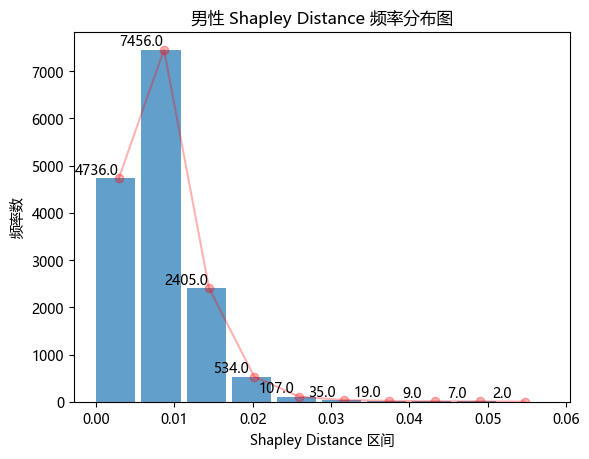

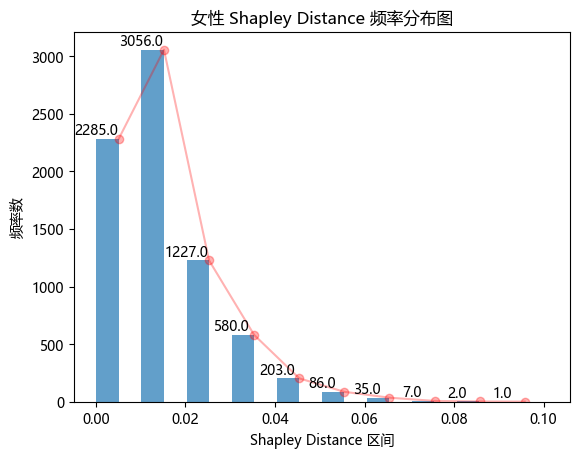

In [15]:
# 可以看到 大于 0.04 的数据比较少，说明不太合理，认为这些是不合理的数据
plt_hist_freq(shap_distance_male, 10, xlabel="Shapley Distance 区间", ylabel="频率数", title="男性 Shapley Distance 频率分布图")
plt_hist_freq(shap_distance_female, 10, xlabel="Shapley Distance 区间", ylabel="频率数", title="女性 Shapley Distance 频率分布图")


In [16]:
# 所以设定阈值为 t=0.04
t = 0.04
# 统计大于阈值的数量
np.sum(shap_distance_male > t), np.sum(shap_distance_female > t)

(20, 341)

## 获得公平和不公平的 idx

In [17]:
# 统计大于阈值的 index
unfair_idx_male = np.where(shap_distance_male > t)
fair_idx_male = np.where(shap_distance_male <= t)
assert len(shap_distance_male) == len(unfair_idx_male[0]) + len(
    fair_idx_male[0]
), "和不相等"
# 女性
unfair_idx_female = np.where(shap_distance_female > t)
fair_idx_female = np.where(shap_distance_female <= t)
assert len(shap_distance_female) == len(unfair_idx_female[0]) + len(
    fair_idx_female[0]
), "和不相等"

In [18]:
## 一个很简单的测试
print("不公平的idx", unfair_idx_male[0])
## 随机选一个
test_unfair_idx = unfair_idx_male[0][0]
print("查看计算好的值", shap_distance_male[test_unfair_idx])
## 计算 sdig
print("使用 sdig 直接计算得到", sdig(test_unfair_idx, shapley_values_male, A))

不公平的idx [ 1976  2705  3180  3800  4222  5363  6500  6926  7369  7909  8423  8631
  8758  9350  9880 11293 11430 12371 12463 14746]
查看计算好的值 0.0416298545897007
使用 sdig 直接计算得到 0.0416298545897007


In [19]:
def index_mapper(a, idx1, idx2):
    """索引映射
    已知 b = a[idx1] 且 c = b[idx2]
    要定位 c 在 a 的位置，则 a[idx1[idx2]]"""
    if isinstance(a, np.ndarray):
        return a[idx1[idx2]]
    elif isinstance(a, pd.DataFrame):
        return a.iloc[idx1[idx2]]
    elif isinstance(a, pd.Series):
        return a.iloc[idx1[idx2]]
    raise TypeError("a 的类型是 ", type(a))

In [20]:
from sklearn.neighbors import NearestNeighbors
def get_knn_idx(knn_k, X_train, X_target):
    knn = NearestNeighbors(n_neighbors=knn_k)
    knn.fit(X_train)
    distance, idx = knn.kneighbors(X_target)
    return idx

In [21]:
knn_k = 9

In [22]:
# 获得【男性】公平样本和不公平样本
fair_samples_male = index_mapper(X_train, idxs_iloc_in_X_train_male, fair_idx_male)
unfair_samples_male = index_mapper(X_train, idxs_iloc_in_X_train_male, unfair_idx_male)
knn_idx_male = get_knn_idx(knn_k, fair_samples_male, unfair_samples_male)

In [23]:
# 获得【女性】公平样本和不公平样本
fair_samples_female = index_mapper(X_train, idxs_iloc_in_X_train_female, fair_idx_female)
unfair_samples_female = index_mapper(X_train, idxs_iloc_in_X_train_female, unfair_idx_female)
knn_idx_female = get_knn_idx(knn_k, fair_samples_female, unfair_samples_female)

In [33]:
from scipy import stats

def need_modify_idx(target, y_train, idx1, knn_idxs):
    count = 0
    total = len(target)
    unfair_list = []
    # 对于每个不公平样本进行遍历
    for i in range(total):
        # 不公平样本
        unfair_sample_idx = target[i]
        idx2 = idx1[unfair_sample_idx] # unfair_sample 在 X_train 上的 idx
        unfair_sample = index_mapper(y_train, idx1, unfair_sample_idx)
        if unfair_sample != y_train.iloc[idx2]:
            raise BaseException("不匹配错误")
        # 近邻的公平样本
        fair_samples_idx = knn_idxs[i]
        knn_samples = index_mapper(y_train, idx1, fair_samples_idx)

        # 统计计算
        fair_mode = stats.mode(knn_samples).mode
        if fair_mode != unfair_sample:
            count += 1
            unfair_list.append(idx2)
    print(f"总数是 {total}，其中有 {count} 个不同", count, total)
    return np.array(unfair_list)
# 获得男性需要改变的 list
unfair_need_modify_male = need_modify_idx(unfair_idx_male[0], y_train, idxs_iloc_in_X_train_male, knn_idx_male)

# 获得女性需要改变的 list
unfair_need_modify_female = need_modify_idx(unfair_idx_female[0], y_train, idxs_iloc_in_X_train_female, knn_idx_female)
# print(sorted(unfair_need_modify_male))
# print(sorted(unfair_need_modify_female))
# print(y_train.iloc[unfair_need_modify_male])
X_train.iloc[5099]

总数是 20，其中有 18 个不同 18 20
总数是 341，其中有 40 个不同 40 341


age               1.273263
workclass         1.703439
fnlwgt           -0.888808
education         0.184396
education.num    -0.423425
marital.status   -0.402341
occupation       -1.034080
relationship     -0.899410
race              0.392980
sex               0.699071
capital.gain     -0.145189
capital.loss     -0.217407
hours.per.week    1.179704
native.country    0.262317
Name: 23862, dtype: float64

In [71]:
# 合并向量
percent_m = 1
shape_male = unfair_need_modify_male.shape[0]
shape_female = unfair_need_modify_female.shape[0]
print(shape_male, shape_female)
m = int(min(shape_male, shape_female) * percent_m)
print(m, type(m))
random_index_male = np.random.choice(shape_male, size=m, replace=False)
random_index_female = np.random.choice(shape_female, size=m, replace=False)
unfair_list_np = np.concatenate((unfair_need_modify_male[random_index_male], unfair_need_modify_female[random_index_female]))
unfair_list_np.shape

18 40
18 <class 'int'>


(36,)

In [72]:
y_train_fair = y_train.copy()
y_train_fair.iloc[unfair_list_np] = 1 - y_train.iloc[unfair_list_np]

In [73]:
xgboost_fair, res_fair = train_model_and_test(
    X_train,
    y_train_fair,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="公平组",
)
res_fair

{'准确率(1)': 0.8632408639574163,
 '精确率(0)': 0.7702060221870047,
 '召回率(1)': 0.6180584993641374,
 'FPR(0)': 0.058704453441295545,
 'FNR(0)': 0.38194150063586263,
 'F1 Score(1)': 0.6857949200376293,
 '人口平等 差异(0)': 0.17066296559050181,
 '人口平等 比率(1)': 0.3207026922441943,
 '机会均等 差异(0)': 0.09014924128731039,
 '机会均等 比率(1)': 0.29340043120986636}

In [74]:
df = pd.DataFrame([res_xgboost_baseline, res_fair],index=["origin", "shap-fair"])
df

,准确率(1),精确率(0),召回率(1),FPR(0),FNR(0),F1 Score(1),人口平等 差异(0),人口平等 比率(1),机会均等 差异(0),机会均等 比率(1)
origin,0.862422,0.768377,0.615939,0.059109,0.384061,0.683765,0.169896,0.322507,0.087648,0.29597
shap-fair,0.863241,0.770206,0.618058,0.058704,0.381942,0.685795,0.170663,0.320703,0.090149,0.29340


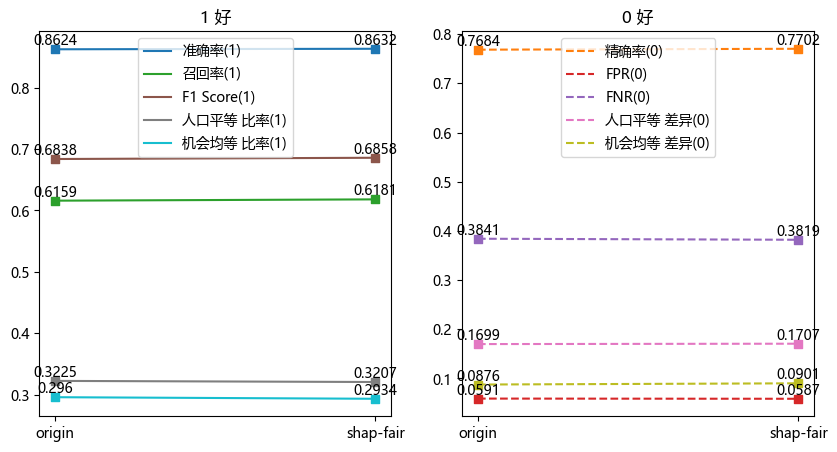

In [75]:
# 画在一张图上
cmap = plt.get_cmap("tab10")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


def plot_sub(ax, title, df: pd.DataFrame, filter, linestyle):
    # 初始化图例对象
    scatter_legend = []
    ax.set_title(title)
    for i, col in enumerate(df.columns):
        if filter(col):
            continue
        values = df[col].values
        x = df.index
        ax.plot(x, values, linestyle=linestyle, label=col, color=cmap(i))
        scatter = ax.scatter(x, values, marker="s", color=cmap(i))
        # 在每个散点的位置添加数值标签
        y = values
        for i in range(len(x)):
            ax.text(x[i], y[i], str(round(y[i], 4)), ha="center", va="bottom")
        # 将散点图的图例对象添加到列表中
        scatter_legend.append(scatter)
    ax.legend()
    # ax.legend(bbox_to_anchor=(1, 1), loc="upper left")


plot_sub(ax1, "1 好", df, lambda x: "1" not in x, "-")
plot_sub(ax2, "0 好", df, lambda x: "0" not in x, "--")

plt.show()